This notebook explores different ways of considering the driving question of `Last 12 months`, different ways of considering compliance, and different ways of comparing `last 12 months`

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from mayavi import mlab

First read in data and clean data

In [2]:
df1 = pd.read_csv('../data/person1-step-data.csv')
df2 = pd.read_csv('../data/person2-step-data.csv')

def clean_raw_df(df):
    # Convert date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Aggregate data into days
    df = df.groupby('Date').sum().reset_index()
    return df

cleaned_1 = clean_raw_df(df1)
cleaned_2 = clean_raw_df(df2)

Different increments: YTD, weeks, months, whole years
Different metrics: average steps per day, total steps in 12 months
if its average steps per day, we could filter out days, and we'd look at different filter metrics

In [3]:
# Main working function
def get_12_mo_comparison(metric, iterator):
    results = []
    for x,y in iterator:
        results.append(metric(x,y))
    return np.array(results)

# Considers days
def decrement_day(dt):
    return dt - timedelta(days = 1)

# Considers months
def decrement_month(dt):
    if dt.month > 1:
        return datetime(year = dt.year, month = dt.month - 1, day = dt.day)
    return datetime(year = dt.year - 1, month = 12, day = dt.day)

# Wraps function so its applied for all args provided
def get_single_return_wrapper(fn):
    def wrapper(*args):
        return [fn(dt) for dt in args]
    return wrapper

# Iterate subsets of time given df, operation to apply after subset, column to extract, and datetime incrementor
def ytd_iter(df, op, col, new_dt):
    start_1 = df['Date'].max()
    end_1 = datetime(year = start_1.year - 1, month = start_1.month, day = start_1.day)
    end_2 = datetime(year = start_1.year - 2, month = start_1.month, day = start_1.day)
    while end_2 >= df['Date'].min():
        y1 = df[(df['Date'] <= start_1) & (df['Date'] > end_1)][col] # Previous 12 months
        y2 = df[(df['Date'] <= end_1) & (df['Date'] > end_2)][col] # The 12 months before that
        yield op(y1), op(y2)
        start_1, end_1, end_2 = new_dt(start_1, end_1, end_2)

# Percentage where we walked more in the last 12 months to the 12 months before
def perc_greater(arr):
    return np.mean(arr>0)


0.603448275862069


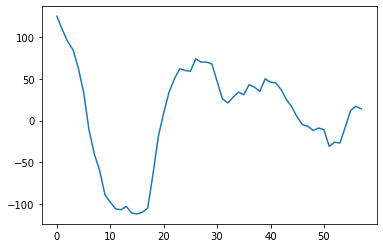

In [4]:
def percent_metric(x,y, goal = 10000):
    return np.sum(x >= goal) - np.sum(y >= goal)
pas = lambda x:x
res_1_days_sum = get_12_mo_comparison(percent_metric, ytd_iter(cleaned_1, pas, 'Count', get_single_return_wrapper(decrement_month)))
print(perc_greater(res_1_days_sum))
plt.plot(res_1_days_sum)

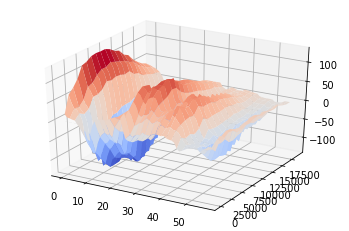

In [5]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
X, Y, Z = [], [], []
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for lim in range(0,20000,1000):
    curr_met = lambda x,y : percent_metric(x,y,lim)
    cmpr = get_12_mo_comparison(curr_met, ytd_iter(cleaned_1, pas, 'Count', get_single_return_wrapper(decrement_month)))
    Z.append(cmpr)
    X.append(list(range(len(cmpr))))
    Y.append([lim]*len(cmpr))
X,Y,Z = np.asarray(X),np.asarray(Y),np.asarray(Z)

xx, yy = np.meshgrid(range(10), range(10))
z = np.zeros_like(xx)

# plot the plane
ax.plot_surface(xx, yy, z, alpha=0.5)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0)

In [6]:
def test_surf():
    """Test surf on regularly spaced co-ordinates like MayaVi."""
    def f(x, y):
        sin, cos = np.sin, np.cos
        return sin(x + y) + sin(2 * x - y) + cos(3 * x + 4 * y)

    x, y = np.mgrid[-7.:7.05:0.1, -5.:5.05:0.05]
    print(x.shape,y.shape,f(x,y).shape)
    s = mlab.surf(x, y, f(x,y))
    #cs = contour_surf(x, y, f, contour_z=0)
    return x,y,f(x,y)
x,y,z = test_surf()
mlab.show()


(141, 201) (141, 201) (141, 201)


In [14]:
(Z-Z.mean())/Z.std()

array([[ 0.29945061,  0.16048965,  0.14063808, ..., -0.05787758,
         0.08108338,  0.08108338],
       [ 1.17291954,  0.79573977,  0.51781784, ..., -0.21669012,
        -0.19683855, -0.27624482],
       [ 1.41113833,  0.93470074,  0.47811471, ..., -0.03802602,
         0.18034121,  0.12078651],
       ...,
       [ 0.89499761,  0.81559134,  0.71633351, ...,  0.00167712,
         0.00167712,  0.00167712],
       [ 0.77588821,  0.71633351,  0.63692724, ..., -0.07772915,
        -0.07772915, -0.07772915],
       [ 0.55752098,  0.49796628,  0.45826314, ..., -0.07772915,
        -0.07772915, -0.07772915]])

In [26]:
s1 = mlab.surf(Y, X, np.zeros_like(Z), warp_scale='auto', opacity = 0.3)
s = mlab.surf(Y, X, (Z/Z.max()), warp_scale='auto')
mlab.axes(xlabel='Step goal', ylabel='time(month)', zlabel='days better 12mo')
mlab.show()

![title](snapshot.png)